
# **1 简介**

目前，药品购买者可以获得各种信息，既可以是数字标签，也可以是文字评论。然而，有用和全面信息的主要来源是文字评论。你可以了解到药物的有效性、药物的副作用和其他注意事项。在广泛接触在线评论网站和论坛的情况下，消费者往往发现很难涵盖所有必要的信息。一个能提供重要质量的评论分类的算法可以起到救急的作用。

因此，这个项目的目的是对文本数据进行分类：第一，关于处方药的有效性，第二，关于药物的副作用，第三，关于药物的综合评价。

也许所进行的研究将帮助药品消费者做出正确的选择，同时节省了解信息的时间成本。


# **2 主要假设**

在该项目中，主要包括以下步骤：

    建立语料库
    数据清洗
    语料库的描述性统计
    准备文件-术语矩阵
    聚类分析

In [4]:
# 加载数据库
library(ggplot2)
library(tidyverse)
library(tm)
library(wordcloud2)
library(dplyr)
library(clustertend)
library(factoextra)
library(gridExtra)
library(cluster)

# **3 数据集的描述**

该项目中使用的数据集呈现了患者对特定药物以及相关疾病的评论。此外，上述评论被分为三组：药品的作用、副作用和总体评论。数据的作者通过抓取在线药品评论网站得到这个数据集。

这些数据是由美国堪萨斯州曼哈顿堪萨斯州立大学的Surya Kallumadi教授和德国德累斯顿工业大学生物医学技术研究所的Felix Gräßer收集的。

https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29

先来总结一下数据。

In [8]:
train <- read_tsv("drugLibTrain_raw.tsv", col_names = TRUE)
test <- read_tsv("drugLibTest_raw.tsv", col_names = TRUE)
df <- full_join(train, test)

names(df)

New names:
• `` -> `...1`
Rows: 3107 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): urlDrugName, effectiveness, sideEffects, condition, benefitsReview,...
dbl (2): ...1, rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1036 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): urlDrugName, effectiveness, sideEffects, condition, benefitsReview,...
dbl (2): ...1, rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("...1", "urlDrugName", "rating", "effectiveness",
"sideEffects", "condition", "benefitsReview", "sideEffectsReview",
"commentsReview")


[1] "...1"              "urlDrugName"       "rating"           
[4] "effectiveness"     "sideEffects"       "condition"        
[7] "benefitsReview"    "sideEffectsReview" "commentsReview"

In [10]:
names(train) = c("ID", "urlDrugName", "rating", "effectiveness", "sideEffects", "condition", "benefitsReview", "sideEffectsReview",  "commentsReview")

names(test) = c("ID", "urlDrugName", "rating", "effectiveness", "sideEffects", "condition", "benefitsReview", "sideEffectsReview",  "commentsReview")

names(df) = c("ID", "urlDrugName", "rating", "effectiveness", "sideEffects", "condition", "benefitsReview", "sideEffectsReview",  "commentsReview")

summary(df)

       ID       urlDrugName            rating       effectiveness     
 Min.   :   0   Length:4143        Min.   : 1.000   Length:4143       
 1st Qu.:1042   Class :character   1st Qu.: 5.000   Class :character  
 Median :2083   Mode  :character   Median : 8.000   Mode  :character  
 Mean   :2082                      Mean   : 6.946                     
 3rd Qu.:3124                      3rd Qu.: 9.000                     
 Max.   :4161                      Max.   :10.000                     
 sideEffects         condition         benefitsReview     sideEffectsReview 
 Length:4143        Length:4143        Length:4143        Length:4143       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                         

In [11]:
glimpse(df)

Rows: 4,143
Columns: 9
$ ID                <dbl> 2202, 3117, 1146, 3947, 1951, 2372, 1043, 2715, 1591…
$ urlDrugName       <chr> "enalapril", "ortho-tri-cyclen", "ponstel", "prilose…
$ rating            <dbl> 4, 1, 10, 3, 2, 1, 9, 10, 10, 1, 7, 8, 8, 9, 4, 8, 6…
$ effectiveness     <chr> "Highly Effective", "Highly Effective", "Highly Effe…
$ sideEffects       <chr> "Mild Side Effects", "Severe Side Effects", "No Side…
$ condition         <chr> "management of congestive heart failure", "birth pre…
$ benefitsReview    <chr> "slowed the progression of left ventricular dysfunct…
$ sideEffectsReview <chr> "cough, hypotension , proteinuria, impotence , renal…
$ commentsReview    <chr> "monitor blood pressure , weight and asses for resol…


数据集中的属性描述

    属性 1: urlDrugName (categorical): 药品名称

    属性 2: rating (numerical): 用户评分（10颗星）

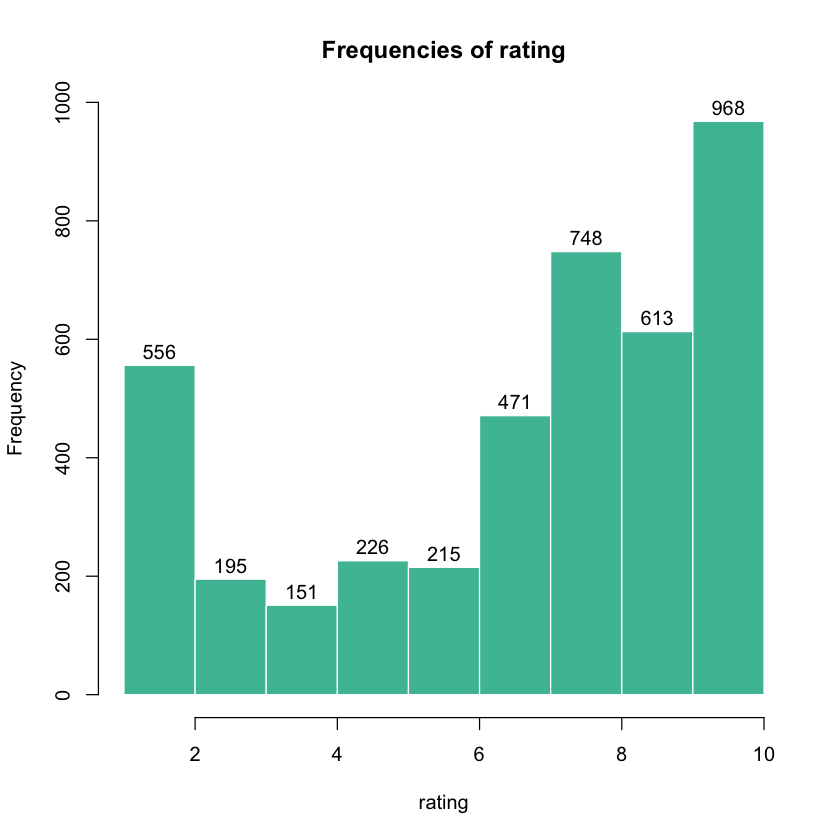

In [12]:
hist(as.numeric(df$rating), breaks = 10, main = "Frequencies of rating", 
     xlab = "rating", col = "#4cbea3", labels = TRUE, border = "#FFFFFF")

根据评级频率图可以看到，有968种药物的评级最好，有556种药物的评级最差。
    
    属性 3: effectiveness (categorical): 药物有效性评分（5个种类）



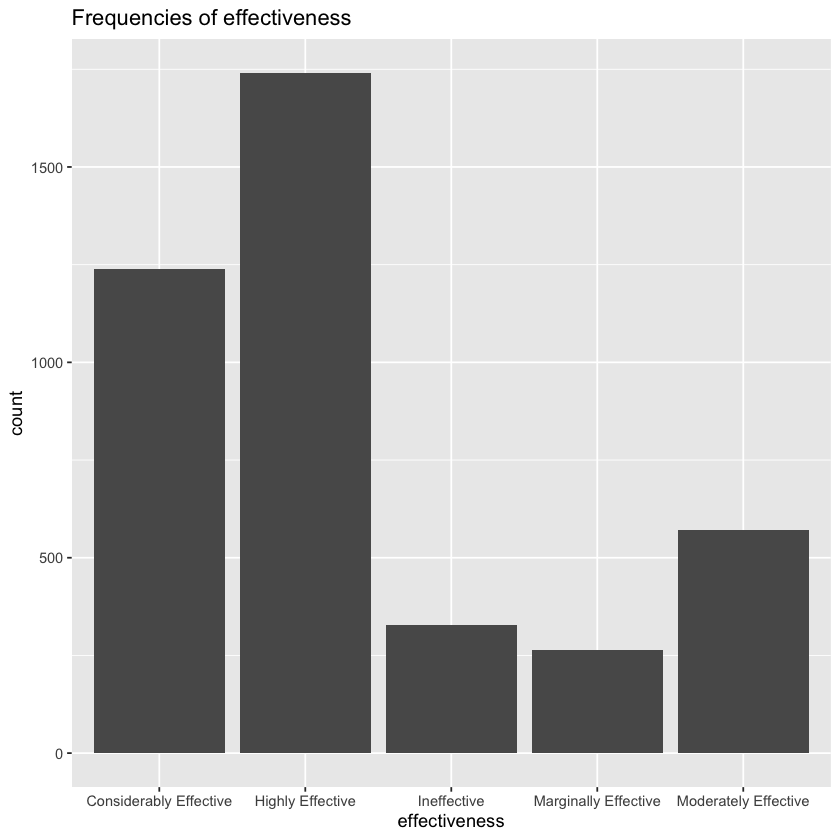

In [13]:
ggplot(df, aes(x=effectiveness)) + geom_bar(stat="count") + ggtitle("Frequencies of effectiveness")

大多数药物被标记为相当有效和高度有效。根据这些结果，我们可以得出对于药物是否有效的评论中大多包含的是正面评价。



In [14]:
df %>%
  group_by(effectiveness) %>%
  summarize(rating_mean = mean(rating))

effectiveness,rating_mean
<chr>,<dbl>
Considerably Effective,7.301292
Highly Effective,8.771396
Ineffective,1.592705
Marginally Effective,3.288973
Moderately Effective,5.384615


此外，上述类别的 "相当有效 "和 "高度有效 "获得最高评级。

    属性 4: sideEffects (categorical): 药物副作用评分（5个种类）

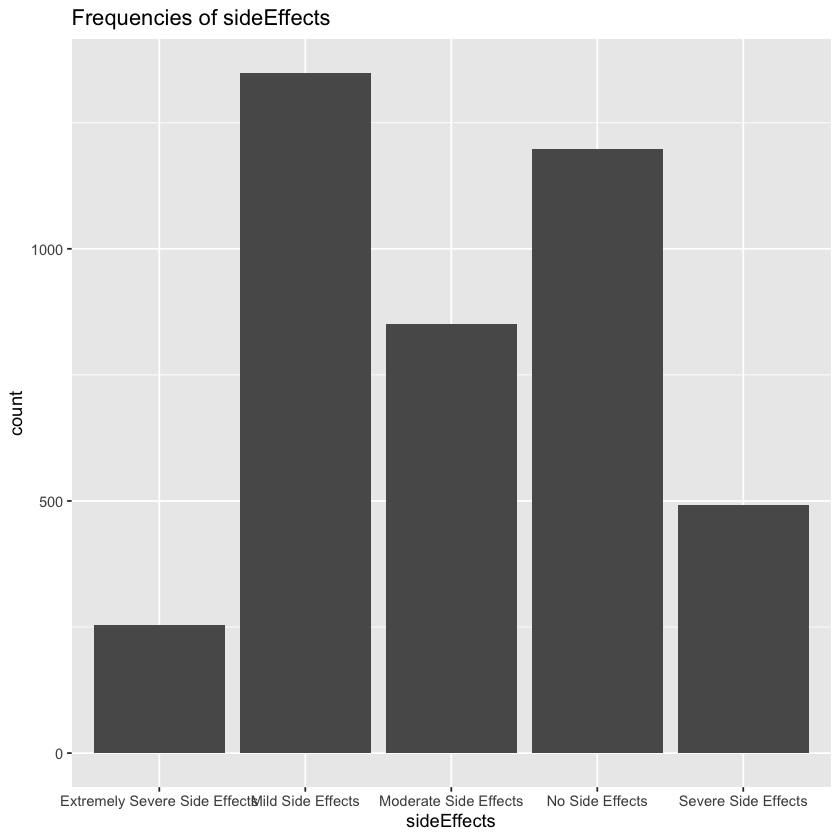

In [15]:
ggplot(df, aes(x=sideEffects)) + geom_bar(stat="count")+ ggtitle("Frequencies of sideEffects")

一般来说，数据集中考虑的药物在大多数情况下有轻微的副作用和没有副作用。根据这些结果，我们可以预期变量sideEffectsReview应该包括有轻微副作用的评论。

In [16]:
df %>%
  group_by(sideEffects) %>%
  summarize(rating_mean = mean(rating))

sideEffects,rating_mean
<chr>,<dbl>
Extremely Severe Side Effects,1.662745
Mild Side Effects,8.133432
Moderate Side Effects,6.183529
No Side Effects,8.653589
Severe Side Effects,3.584521


药品的最高评价是无副作用，副作用轻微。

    属性 5: condition (categorical): 治疗症状名称
    属性 6: benefitsReview (text): 病人对于药物有效性的评论
    属性 7: sideEffectsReview (text): 病人对于药物副作用的评论
    属性 8: commentsReview (text): 病人对于药物的总体评论

# **4 准备建模的数据**

我们将为三个评论构建分析：commentsReview，sideEffectsReview，benefitReview

# 4.1 commentsReview 综合评论

建立模型的第一个阶段是创建语料库。通过直观地分析评论，我们可以看到其中一些评论非常相似。

下一步是清理主体：

stripWhitespace - 去除空白部分 

removePunctuation - 去掉标点符号 

removeNumbers - 去除数字 

content_transformer (tolower) - 将任何单词转换为小写字母 

removeWords - 去除单词的停顿 

stemDocument - 去除单词的词根


VectorSource(x) : Takes a grouping of texts and makes each element of the resulting vector a document within your R Workspace. There are many types of sources, but VectorSource() is made for working with character objects in R. VCorpus(): Takes a source object and makes a volatile corpora.

VectorSource(x) : 获取一组文本，并使产生的向量中的每个元素成为你的R工作区中的文件。有许多类型的源，但VectorSource()是为在R中处理字符对象而做的。 
VCorpus()：获取一个源对象并制作一个易失性的语料库。

In [10]:
install.packages("SnowballC")
library(SnowballC)

# 建立语料库
docs <- VCorpus(VectorSource(df$commentsReview))

# 语料库清洗
toSpace <- content_transformer(function (x, pattern) gsub(pattern, " ", x))
docs <- tm_map(docs, toSpace, "/")
docs <- tm_map(docs, toSpace, "@")
docs <- tm_map(docs, toSpace, "\\|")


docs <- tm_map(docs, removePunctuation)
docs <- tm_map(docs, removeNumbers)
docs <- tm_map(docs, content_transformer(tolower))
docs <- tm_map(docs, stripWhitespace)
docs = tm_map(docs, removeWords, c(stopwords("en"), "howev", "just", "due", "still", "per", "also", "aaaaarrrgh", "aana", "aarp", "abdo", "abbout", "abcess", "aboc", "abruptlyand", "even", "morn"))

# 去除词根
docs <- tm_map(docs, stemDocument)

# 生成文档-术语矩阵
dtm <- DocumentTermMatrix(docs)
dtm


The downloaded binary packages are in
	/var/folders/hj/xz5cqr414qxby0l8k0yb49c80000gn/T//RtmpKf4a4q/downloaded_packages


<<DocumentTermMatrix (documents: 4143, terms: 7686)>>
Non-/sparse entries: 86386/31756712
Sparsity           : 100%
Maximal term length: 37
Weighting          : term frequency (tf)

文档-术语矩阵是一个数学矩阵，它描述了在一个文档集合中出现的术语的频率。在一个文档术语矩阵中，行对应于集合中的文档，列对应于术语。

In [11]:
# 移除稀有的词语
dtms <- removeSparseTerms(dtm, sparse = 0.97)

m <- as.matrix(dtms)

# 画图
m_freq = as.matrix(rowSums(m))

sd = sd(m_freq)
sd
mean = mean(m_freq)
mean

[1] 9.965209

[1] 10.99686

根据描述性统计和基本图表，我们可以看到，经过清理的数据：

    上述数据的平均值为10.99
    清理后的数据的标准差为9.96
    直方图和箱形图显示了经清理的数据的分布情况。

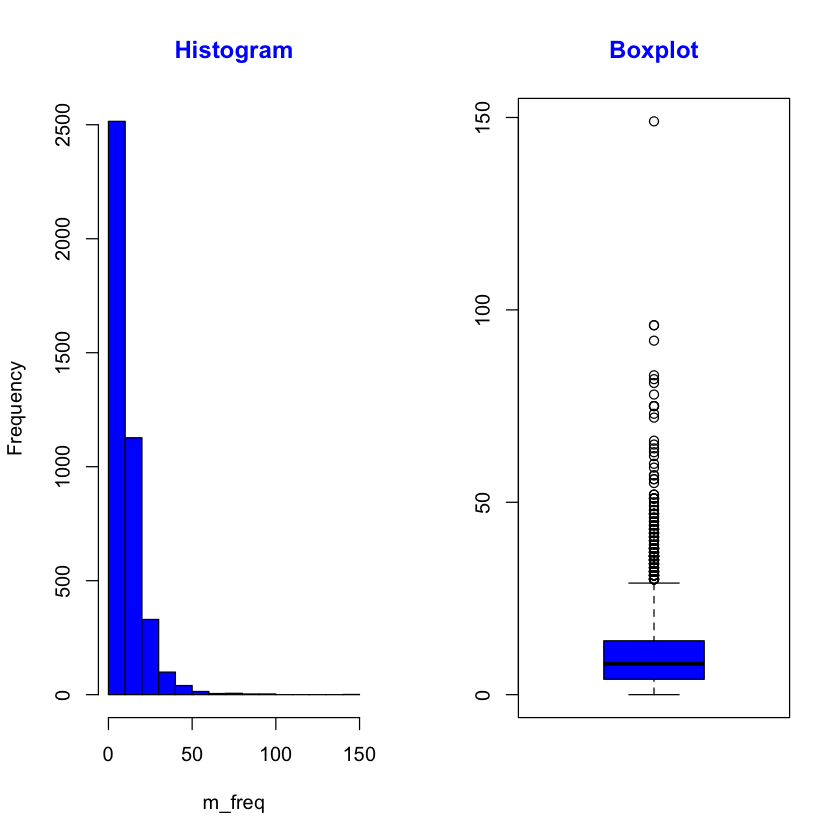

In [22]:
par(mfrow = c(1,2))

hist(m_freq,
     main = "Histogram",
     col = "blue",
     col.main = "blue")
boxplot(m_freq, 
        main = "Boxplot", 
        col = "blue",
        col.main = "blue")

In [63]:
tdm_1 <- TermDocumentMatrix(docs)
tdm_2 <- as.matrix(tdm_1)
tdm_2[1:20,1:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
abandon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abbrevi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abcess,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aberr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abilifi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


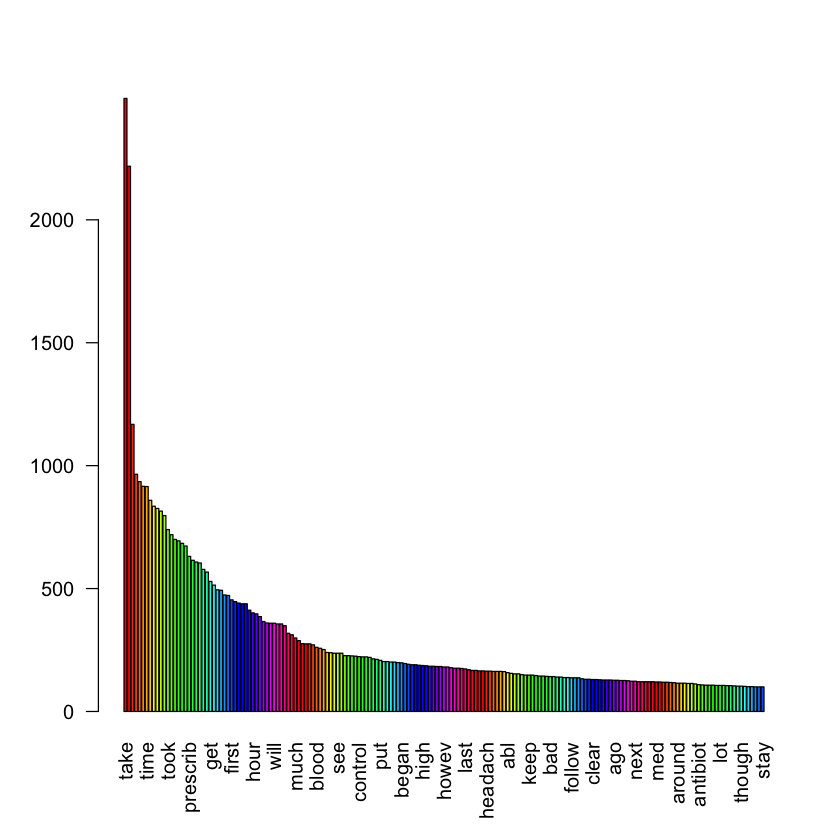

In [140]:
w <- sort(rowSums(tdm_2),decreasing=TRUE) # 病人所用词汇的数量排名
d <- subset(w, w>= 100) # 筛选出出现次数大于等于100的词汇
barplot(d, las = 2, col = rainbow(50))

In [141]:
library(wordcloud)
library(RColorBrewer)
library(wordcloud2)

,word,freq
,<chr>,<dbl>
take,take,2494
day,day,2218
effect,effect,1168
one,one,965
week,week,935
use,use,916
time,time,915
drug,drug,859
medic,medic,835


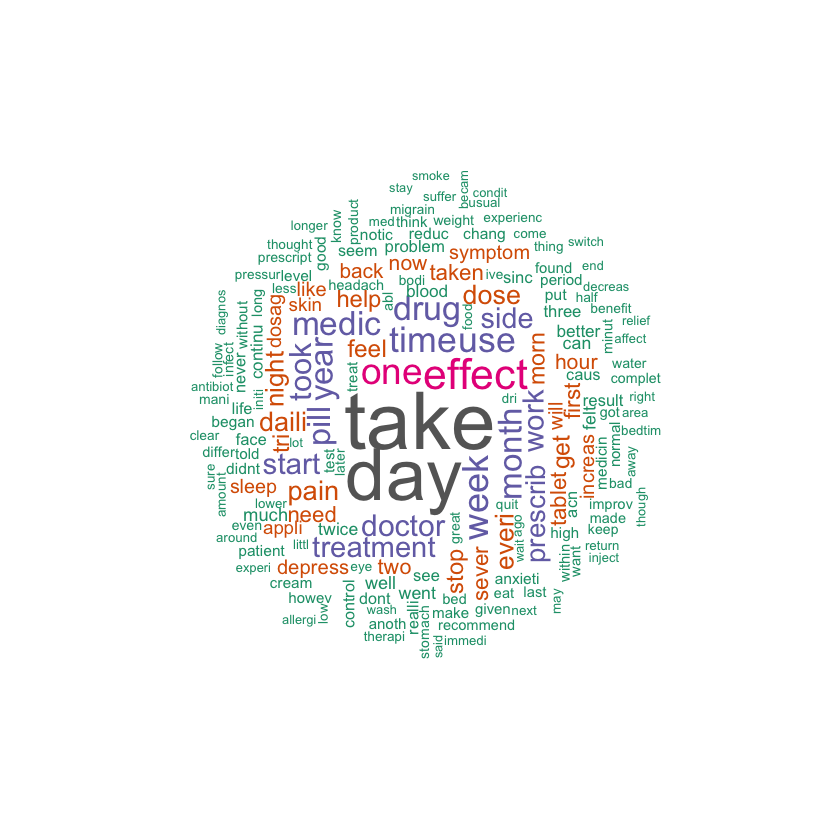

In [142]:
d <- data.frame(word=names(d),freq=d)
head(d,10)

wordcloud(words=d$word,freq=d$freq,min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

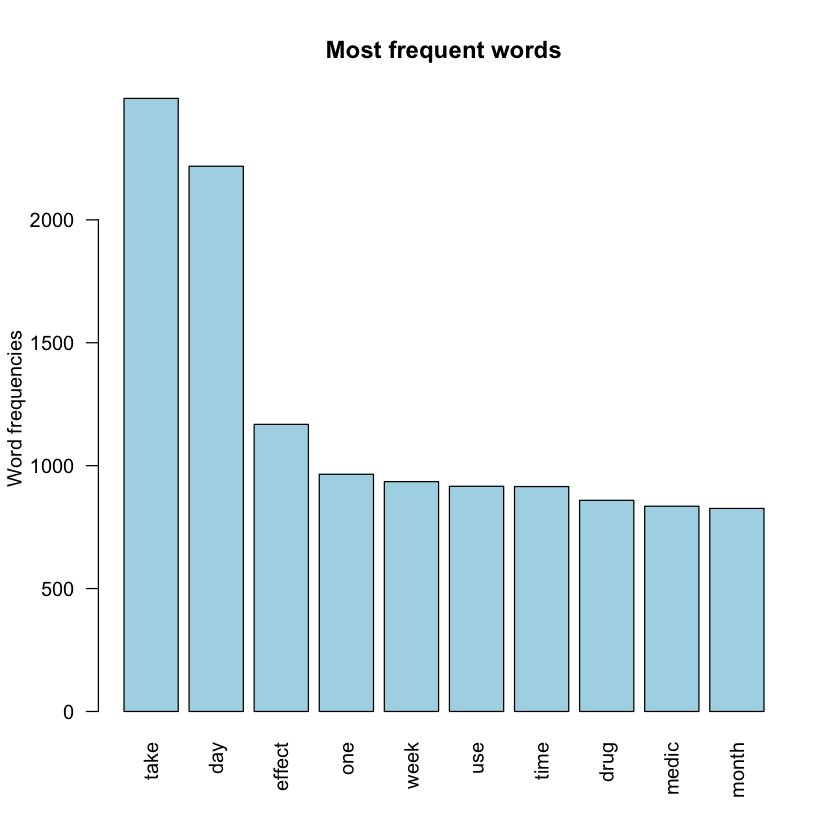

In [150]:
barplot(d[1:10,]$freq, las = 2, names.arg = d[1:10,]$word,
        col ="lightblue", main ="Most frequent words",
        ylab = "Word frequencies")

分析药物总体评论的关键词，可以看到与第一组-有效性有关评论的关键词（"服用"、"日"、"周"、"时间"、"效果"、"医生"、"压抑"、"正常"、"晚上"、"开始 "等）和与第二组-副作用的关键词（"效果"、"服用"、"日"、"时间"、"医生"、"疼痛"、"感觉"、"皮肤 "等）相吻合。

# 4.2 sideEffectsReview 副作用评论

建立模型的第一个阶段是创建语料库。通过直观地分析评论，我们可以看到其中一些评论非常相似。

下一步是语料库清洗

In [145]:
docs1 <- VCorpus(VectorSource(df$sideEffectsReview))

# 语料库清洗
toSpace <- content_transformer(function (x, pattern) gsub(pattern, " ", x))
docs1 <- tm_map(docs1, toSpace, "/")
docs1 <- tm_map(docs1, toSpace, "@")
docs1 <- tm_map(docs1, toSpace, "\\|")

docs1 <- tm_map(docs1, removePunctuation)
docs1 <- tm_map(docs1, removeNumbers)
docs1 <- tm_map(docs1, content_transformer(tolower))
docs1 <- tm_map(docs1, removeWords, stopwords("english"))
docs1 <- tm_map(docs1, stripWhitespace)

# 移除词根 
docs1 <- tm_map(docs1, stemDocument)

# 文档-术语矩阵 
dtm1 <- DocumentTermMatrix(docs1)
                               

# 移除稀少词语
dtms1 <- removeSparseTerms(dtm1, sparse = 0.97)

m1 <- as.matrix(dtms1)

# 画图
m1_freq = as.matrix(rowSums(m1))

sd1 = sd(m1_freq)
sd1
mean1 = mean(m1_freq)
mean1

[1] 6.670123

[1] 6.659908

根据描述性统计和基本图表，我们可以看到，经过清理的数据：

    上述数据的平均值为6.66
    清理后的数据的标准差为6.67
    直方图和箱形图显示了经清理的数据的分布情况。

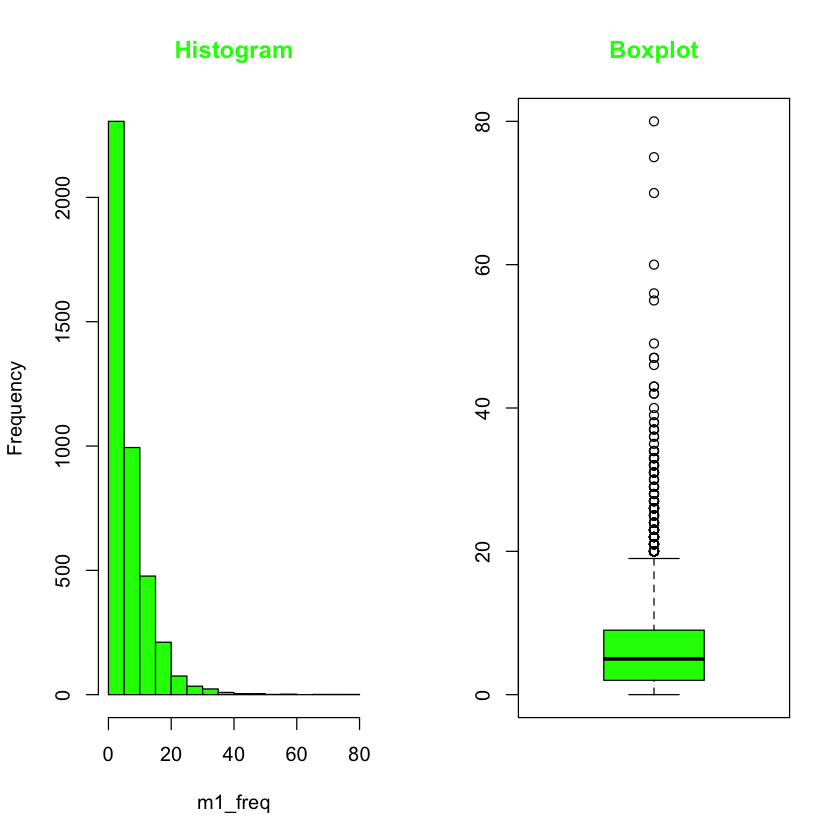

In [30]:
par(mfrow = c(1,2))

hist(m1_freq,
     main = "Histogram",
     col = "green",
     col.main = "green")
boxplot(m1_freq, 
        main = "Boxplot", 
        col = "green",
        col.main = "green")

In [146]:
tdm1_1 <- TermDocumentMatrix(docs1)
tdm1_2 <- as.matrix(tdm1_1)
tdm1_2[1:20,1:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aafter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abbsess,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abfter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abilifi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abit,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


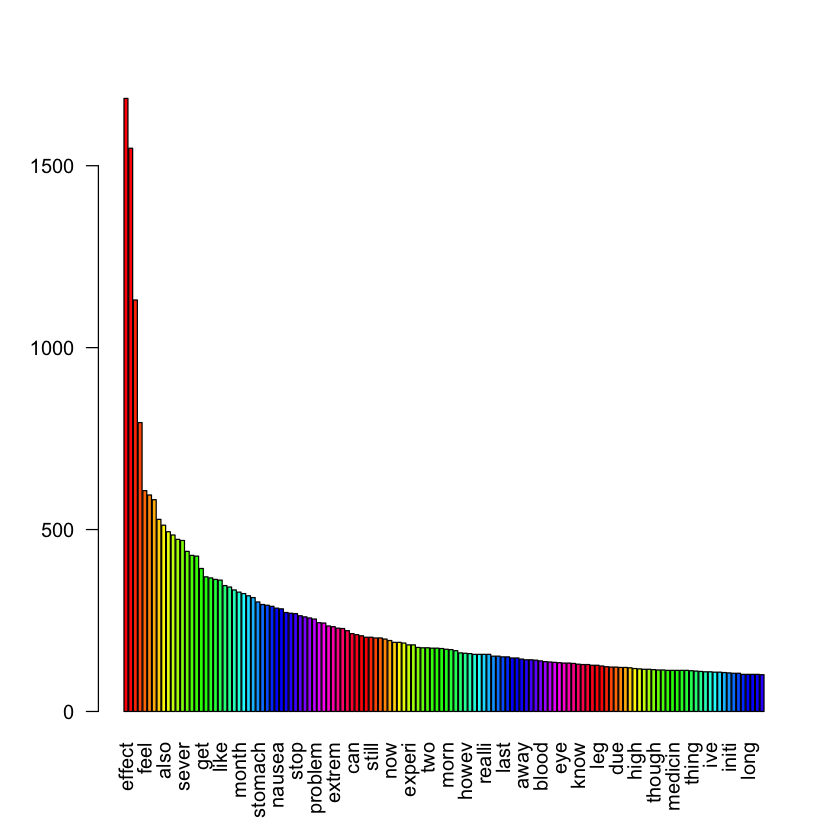

In [147]:
w1 <- sort(rowSums(tdm1_2),decreasing=TRUE) 
d1 <- subset(w1, w1>= 100) 
barplot(d1, las = 2, col = rainbow(50))

,word,freq
,<chr>,<dbl>
effect,effect,1685
side,side,1548
take,take,1131
day,day,794
feel,feel,607
time,time,595
drug,drug,582
none,none,528
also,also,512


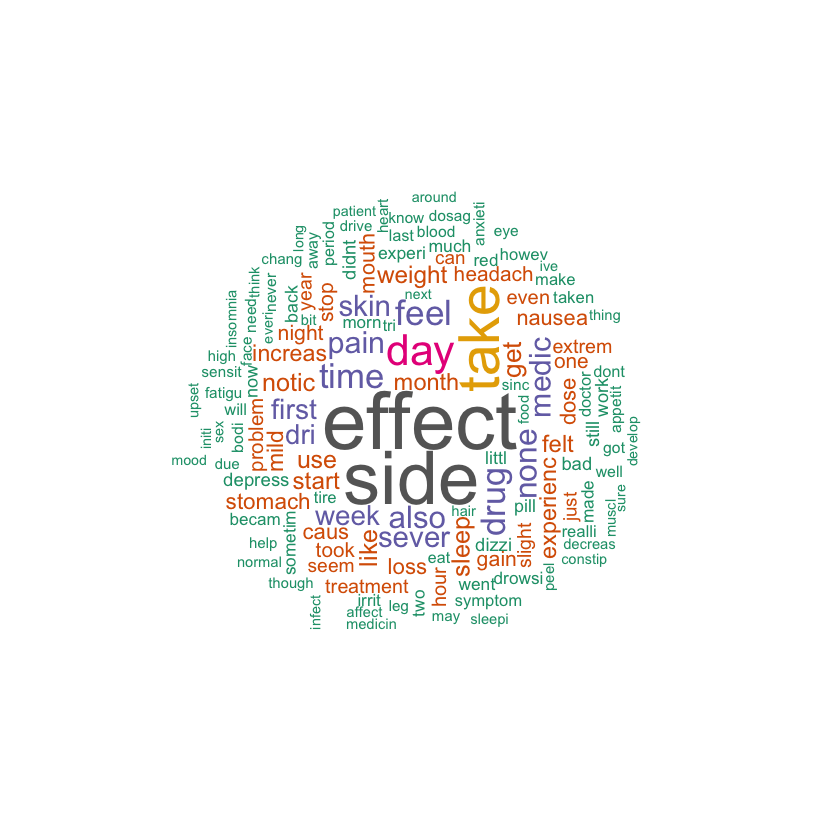

In [148]:
d1 <- data.frame(word=names(d1),freq=d1)
head(d1,10)

wordcloud(words=d1$word,freq=d1$freq,min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

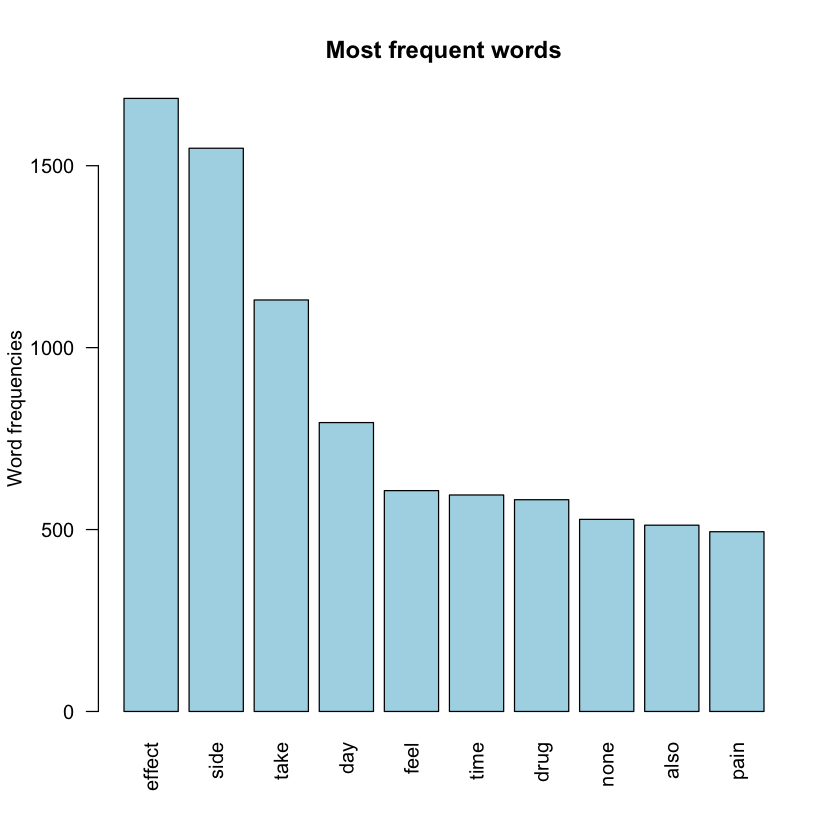

In [149]:
barplot(d1[1:10,]$freq, las = 2, names.arg = d1[1:10,]$word,
        col ="lightblue", main ="Most frequent words",
        ylab = "Word frequencies")

诸如 "效果"、"副作用"、"服用"、"一天"、"时间"、"药物"、"疼痛"、"感觉"、"第一次"、"胃"、"头痛"、"皮肤"、"体重 "等词汇的使用频率高于其他词汇。服用规定的药物，在服用药物的头几天/几周，病人感到有以下问题；腹痛、头痛、皮肤过敏。


# 4.3  benefitsReview 有效性评论

In [151]:
docs2 <- VCorpus(VectorSource(df$benefitsReview))

# 语料库清洗
toSpace <- content_transformer(function (x, pattern) gsub(pattern, " ", x))
docs2 <- tm_map(docs2, toSpace, "/")
docs2 <- tm_map(docs2, toSpace, "@")
docs2 <- tm_map(docs2, toSpace, "\\|")

docs2 <- tm_map(docs2, removePunctuation)
docs2 <- tm_map(docs2, removeNumbers)
docs2 <- tm_map(docs2, content_transformer(tolower))
docs2 <- tm_map(docs2, removeWords, stopwords("english"))
docs2 <- tm_map(docs2, stripWhitespace)
docs2 = tm_map(docs2, removeWords, c(stopwords("en"), "also", "abfter", "aboveand", "even", "will", "just", "didnt", "dont", "howev", "due", "still", "per", "aaaaarrrgh", "aana", "aarp", "abdo", "abbout", "abcess", "aboc", "abruptlyand", "even"))

# 去除词根
docs2 <- tm_map(docs2, stemDocument)

# 文档-术语矩阵
dtm2 <- DocumentTermMatrix(docs2)

# 移除稀缺词
dtms2 <- removeSparseTerms(dtm2, sparse = 0.97)


m2 <- as.matrix(dtms2)

# 画图

m2_freq = as.matrix(rowSums(m2))

sd2 = sd(m2_freq)
sd2
mean2 = mean(m2_freq)
mean2

[1] 6.504784

[1] 7.533189

根据描述性统计和基本图表，我们可以看到，经过清理的数据：

    上述数据的平均值为7.53
    清理后的数据的标准差为6.50
    直方图和箱形图显示了经清理的数据的分布情况。


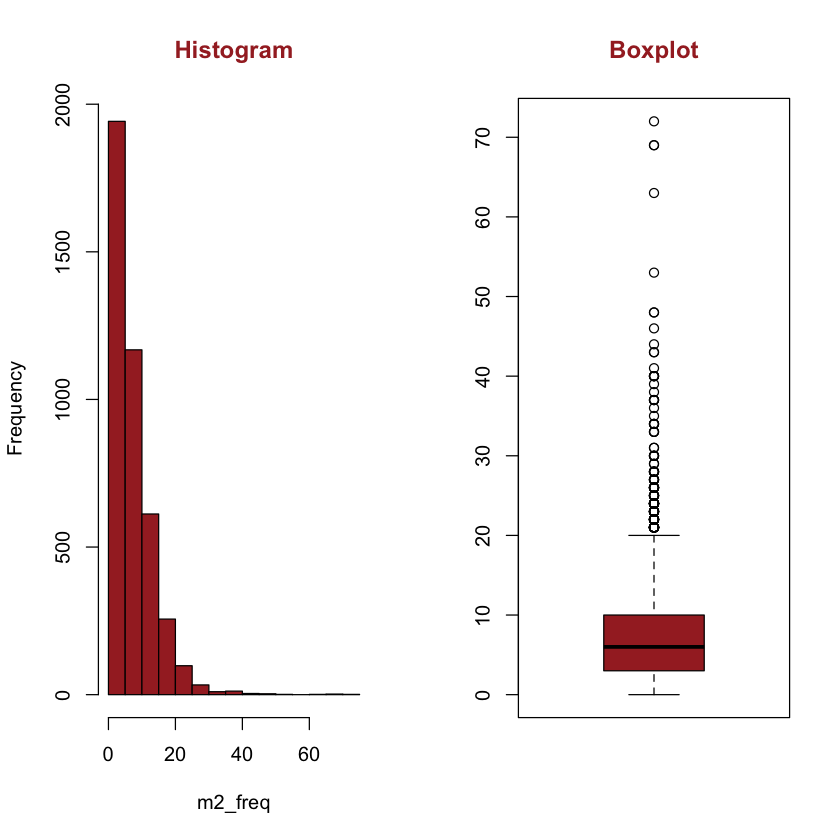

In [35]:
par(mfrow = c(1,2))

hist(m2_freq,
     main = "Histogram",
     col = "brown",
     col.main = "brown")
boxplot(m2_freq, 
        main = "Boxplot", 
        col = "brown",
        col.main = "brown")

In [36]:
tdm2_1 <- TermDocumentMatrix(docs2)
tdm2_2 <- as.matrix(tdm2_1)
tdm2_2[1:20,1:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
aand,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aarm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abait,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abcess,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdomin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abdominfirst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


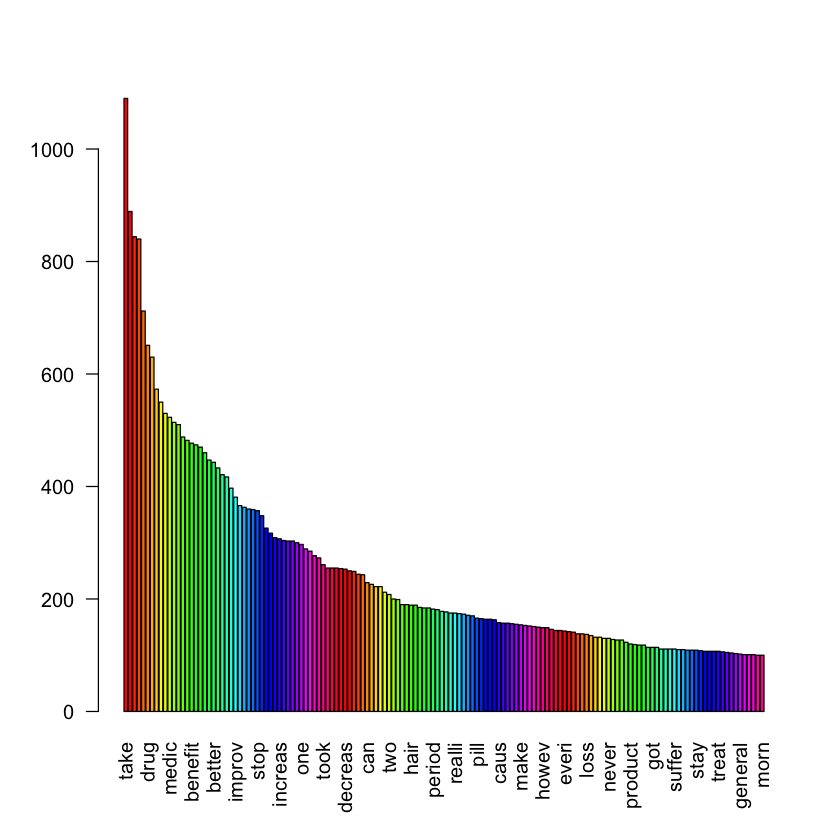

In [152]:
w2 <- sort(rowSums(tdm2_2),decreasing=TRUE) # the number of terms used by patient
d2 <- subset(w2, w2>= 100) # The terms >= 100 times
barplot(d2, las = 2, col = rainbow(50))

,word,freq
,<chr>,<dbl>
take,take,1090
effect,effect,889
pain,pain,844
day,day,840
help,help,712
drug,drug,651
feel,feel,630
time,time,573
work,work,550


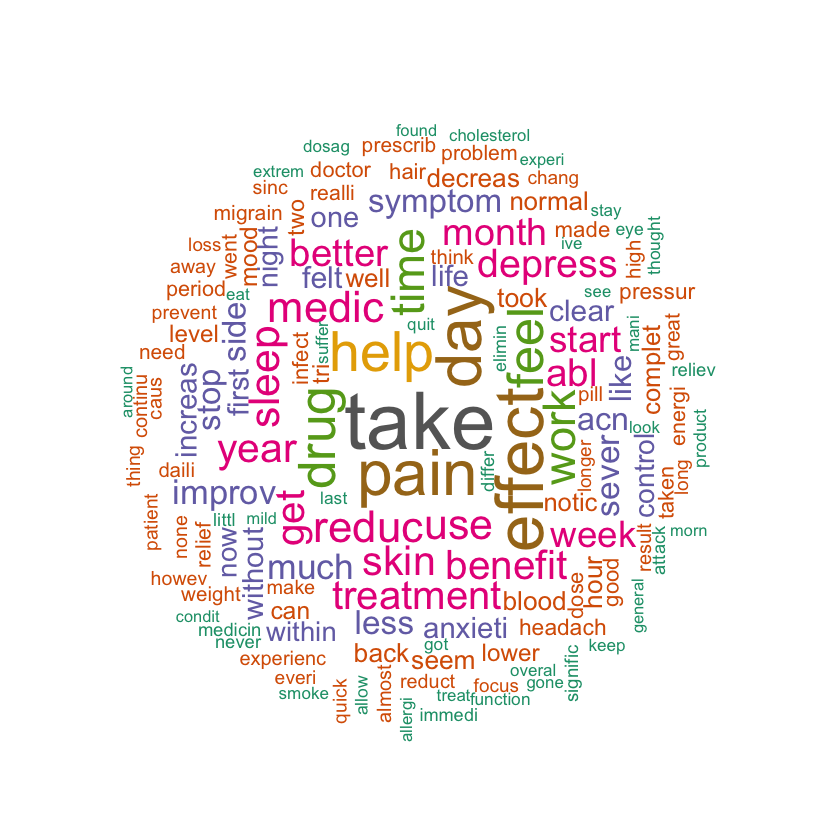

In [153]:
d2 <- data.frame(word=names(d2),freq=d2)
head(d2,10)

wordcloud(words=d2$word,freq=d2$freq,min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, colors=brewer.pal(8, "Dark2"))

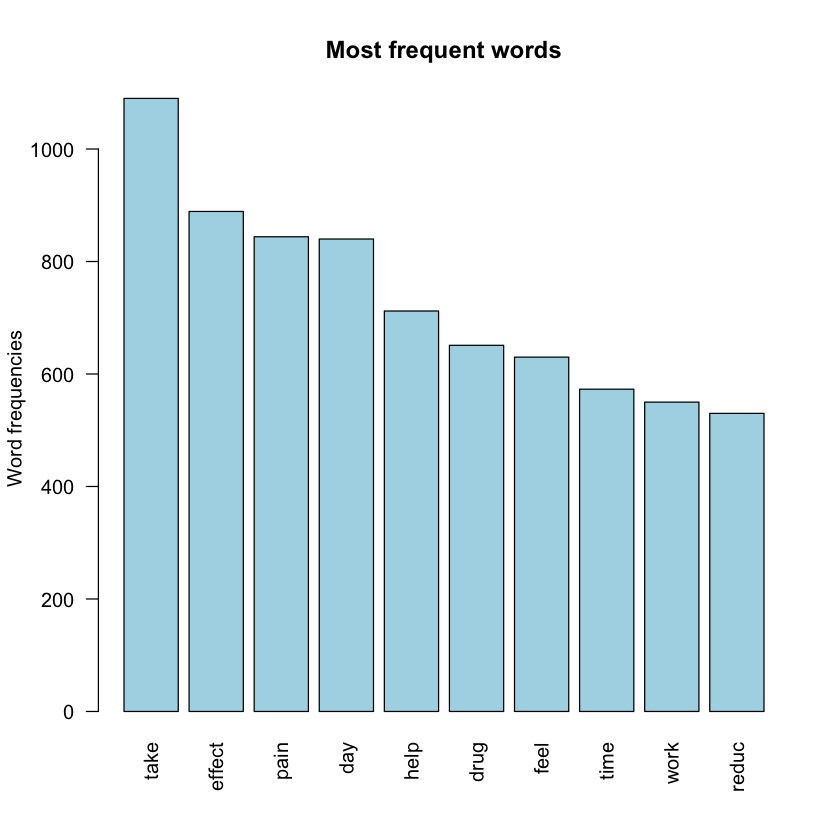

In [154]:
barplot(d2[1:10,]$freq, las = 2, names.arg = d2[1:10,]$word,
        col ="lightblue", main ="Most frequent words",
        ylab = "Word frequencies")

患者在评论中经常使用的总体评论的词语是 "服用"、"一天"、"一周"、"时间"、"效果"、"医生"、"抑郁"、"早晨"、"药丸"、"晚上"、"开始 "等。我们可以推断：医生开的药会产生效果，经过一段时间/一周的剂量，病人在白天感觉好多了，抑郁症减少了，早晨出现了活力，睡眠改善了。

# 5 建模

# 5.1 commentsReview

为了应用聚类分析，有必要先确定聚类的最佳数量。

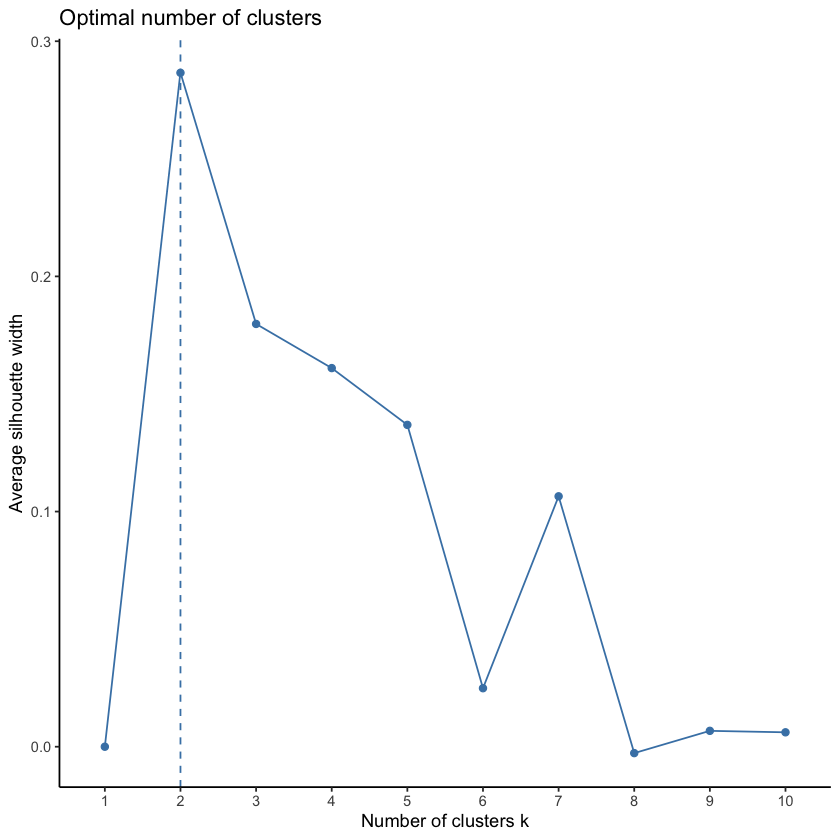

In [182]:
fviz_nbclust(m, FUNcluster = kmeans, method = "silhouette") + theme_classic() 

根据Silhouette统计学，对于K Means来说，最佳的聚类数目是2。

下一步我们将用K Means进行聚类。

# 5.1.1 K Means 聚类分析

In [156]:
# 计算文档向量之间的距离
d <- dist(m, method="euclidian")

# k means - k=2
ncl=2
kfit <- kmeans(d, ncl, nstart=100)


创建带有药物ID的集群清单

In [157]:
cl_k = as.data.frame(kfit$cluster)

# Generate list of clusters for gdugs
ncl = 2
cl = list()
for (i in 1:ncl) {
cl[paste("cl_",i, sep = "")] = list(rownames(subset(cl_k, cl_k == i)))
}
cl

$cl_1
  [1] "3"    "9"    "14"   "22"   "33"   "34"   "46"   "48"   "50"   "54"  
 [11] "56"   "64"   "72"   "82"   "84"   "92"   "102"  "106"  "107"  "112" 
 [21] "126"  "129"  "144"  "146"  "147"  "152"  "155"  "157"  "168"  "195" 
 [31] "198"  "200"  "202"  "208"  "218"  "223"  "228"  "234"  "235"  "240" 
 [41] "248"  "251"  "257"  "279"  "280"  "281"  "288"  "289"  "290"  "295" 
 [51] "326"  "328"  "369"  "373"  "376"  "377"  "384"  "386"  "387"  "395" 
 [61] "411"  "413"  "415"  "423"  "426"  "435"  "437"  "440"  "464"  "467" 
 [71] "473"  "474"  "485"  "495"  "498"  "504"  "505"  "508"  "509"  "510" 
 [81] "525"  "536"  "537"  "540"  "541"  "558"  "559"  "565"  "567"  "574" 
 [91] "577"  "581"  "582"  "588"  "607"  "621"  "635"  "637"  "648"  "655" 
[101] "659"  "666"  "680"  "682"  "686"  "690"  "702"  "707"  "708"  "712" 
[111] "714"  "716"  "725"  "727"  "730"  "737"  "742"  "750"  "756"  "757" 
[121] "759"  "761"  "762"  "771"  "772"  "773"  "778"  "784"  "786"  "791" 
[131] "793"  "802"  "812"  "814"  "816"  "825"  "826"  "828"  "845"  "848" 
[141] "857"  "861"  "865"  "866"  "880"  "884"  "890"  "891"  "895"  "907" 
[151] "908"  "923"  "924"  "926"  "929"  "935"  "937"  "939"  "948"  "955" 
[161] "973"  "984"  "985"  "989"  "1001" "1003" "1005" "1017" "1018" "1028"
[171] "1031" "1032" "1034" "1041" "1050" "1078" "1084" "1088" "1094" "1095"
[181] "1096" "1097" "1109" "1110" "1118" "1134" "1137" "1139" "1140" "1141"
[191] "1146" "1154" "1160" "1180" "1190" "1193" "1200" "1201" "1208" "1213"
[201] "1224" "1234" "1237" "1243" "1254" "1261" "1263" "1298" "1316" "1317"
[211] "1321" "1327" "1334" "1339" "1351" "1353" "1356" "1372" "1377" "1379"
[221] "1383" "1406" "1429" "1457" "1461" "1464" "1476" "1478" "1489" "1494"
[231] "1498" "1501" "1504" "1507" "1512" "1513" "1532" "1538" "1585" "1597"
[241] "1599" "1603" "1606" "1624" "1626" "1627" "1631" "1634" "1640" "1651"
[251] "1674" "1679" "1690" "1695" "1703" "1724" "1728" "1729" "1730" "1736"
[261] "1747" "1758" "1765" "1769" "1776" "1796" "1813" "1818" "1819" "1827"
[271] "1829" "1834" "1836" "1870" "1871" "1875" "1899" "1900" "1911" "1915"
[281] "1919" "1920" "1922" "1931" "1935" "1946" "1961" "1962" "1963" "1968"
[291] "1989" "1990" "2005" "2006" "2007" "2009" "2018" "2023" "2024" "2032"
[301] "2039" "2040" "2041" "2063" "2068" "2072" "2079" "2082" "2091" "2095"
[311] "2097" "2105" "2112" "2119" "2127" "2139" "2143" "2145" "2147" "2151"
[321] "2167" "2170" "2172" "2175" "2182" "2194" "2196" "2200" "2210" "2211"
[331] "2218" "2219" "2232" "2237" "2238" "2242" "2244" "2250" "2269" "2274"
[341] "2286" "2288" "2293" "2297" "2305" "2308" "2336" "2358" "2360" "2361"
[351] "2364" "2365" "2380" "2386" "2387" "2390" "2401" "2416" "2428" "2434"
[361] "2458" "2462" "2466" "2468" "2473" "2494" "2496" "2505" "2516" "2520"
[371] "2533" "2534" "2538" "2541" "2557" "2563" "2572" "2574" "2578" "2580"
[381] "2586" "2592" "2595" "2605" "2606" "2610" "2621" "2622" "2623" "2625"
[391] "2634" "2639" "2640" "2655" "2661" "2669" "2690" "2694" "2695" "2708"
[401] "2713" "2720" "2725" "2728" "2732" "2736" "2746" "2756" "2761" "2764"
[411] "2770" "2773" "2784" "2788" "2813" "2826" "2838" "2844" "2849" "2862"
[421] "2872" "2875" "2877" "2890" "2901" "2909" "2913" "2918" "2924" "2928"
[431] "2933" "2936" "2937" "2947" "2950" "2958" "2965" "2968" "2969" "2970"
[441] "2977" "2981" "2982" "3001" "3018" "3029" "3035" "3036" "3038" "3040"
[451] "3045" "3048" "3059" "3071" "3077" "3079" "3081" "3089" "3097" "3100"
[461] "3101" "3103" "3104" "3110" "3114" "3116" "3123" "3154" "3159" "3161"
[471] "3164" "3174" "3183" "3190" "3199" "3201" "3205" "3217" "3220" "3234"
[481] "3235" "3241" "3245" "3247" "3249" "3250" "3256" "3257" "3264" "3267"
[491] "3271" "3273" "3275" "3282" "3295" "3297" "3306" "3308" "3312" "3320"
[501] "3326" "3331" "3340" "3341" "3346" "3356" "3362" "3363" "3377" "3378"
[511] "3382" "3389" "3392" "3393" "3395" "3397" "3399" "3402" "3408" "3411"
[521] "3419" "3420" "3423" "3429" "3433" "



我们将在图中呈现两个群组

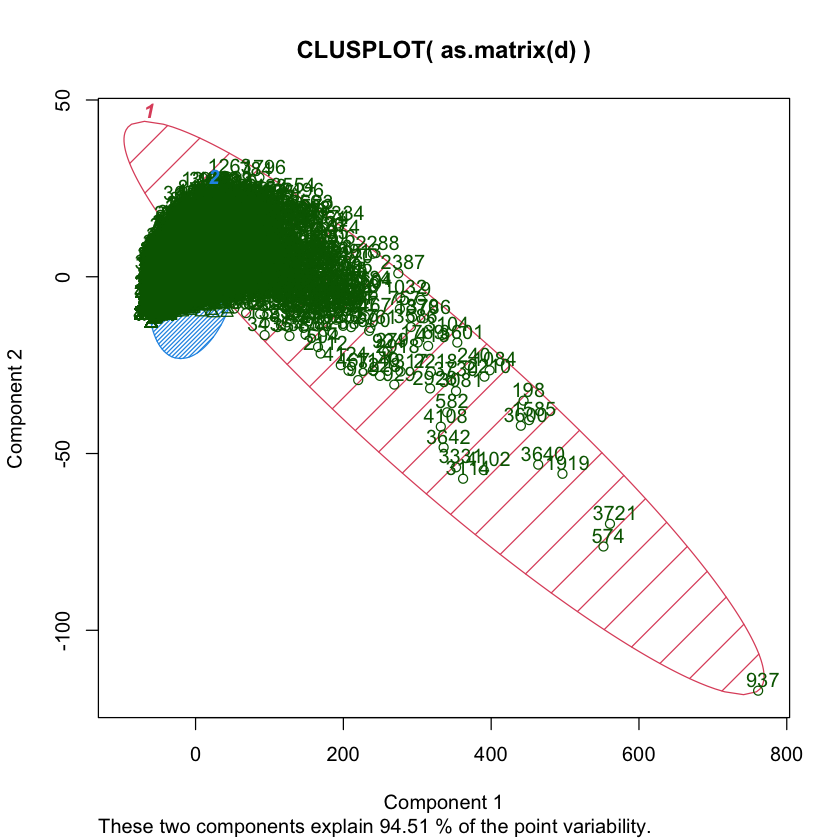

In [158]:
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0)



让我们用最常用的词来分析所构建的群组的可能主题。

Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”
Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”


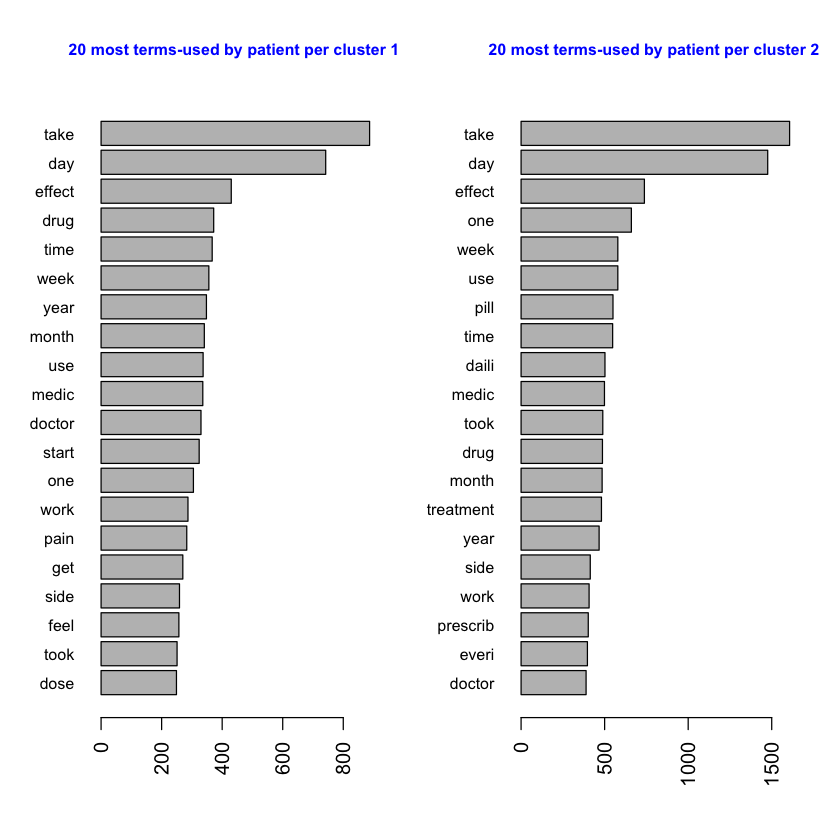

In [159]:
# 为两个集群建立语料库

ncl=2
for (i in 1:ncl) {
  name = paste("cl_corp_", i, sep = "")
  assign(name, docs[match(cl[[i]], names(docs))])
} 

Tdm = list()

# 为两个类群建立TDM
for (i in 1:ncl) {
  bigram_dtm_i = TermDocumentMatrix(get(paste("cl_corp_",i,sep="")))
  tdm_i <- as.matrix(bigram_dtm_i)
  Tdm[paste("cluster_",i,sep="")] = list(tdm_i)
}

# 画出每个类群患者最常用的20个关键词
par(mfrow = c(1,2))
for (i in 1:ncl) {
  cl_m = as.matrix(Tdm[[i]])
  barplot(sort(sort(rowSums(cl_m), decreasing = TRUE)[1:20], decreasing = FALSE),
          las = 2,
          horiz = TRUE,
          decreasing = FALSE, 
          main = paste("20 most terms-used by patient per cluster", i, sep = " "),
          cex.main = 0.8,
          cex.names = 0.8,
          col.main = "blue")
}

从上图中我们可以看到，药物的总体评论可以分成两个主要的类群。

第一组包括以下关键词："开始"、"起效"、"疼痛"、"得到"、"感觉"、"剂量"等。这表明医生按指定剂量开的药会有帮助。病人会感觉到自身状况的改善，疼痛会逐渐消失。

第二组包括以下关键词："药片"、"每日"、"治疗"、"处方"、"每"等。这一组药物与持续服用医生开的药物有关：每天一片。在这种情况下，有必要在医生的监督下进行。

# 5.2 sideEffectsReview

先确定最佳的类群数量。

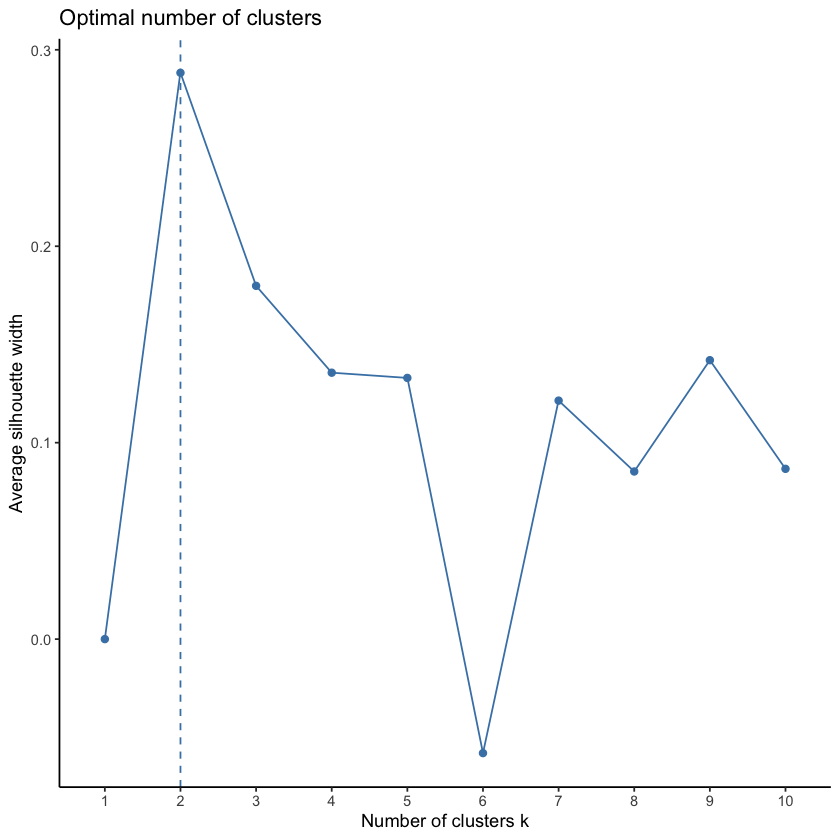

In [183]:
fviz_nbclust(m1, FUNcluster = kmeans, method = "silhouette") + theme_classic() 

根据Silhouette统计，kmeans的最佳集群数为2


# 5.2.1 K Means 聚类分析

In [167]:
# 计算文件向量之间的距离
d1 <- dist(m1, method="euclidian")
# k means - k=2
ncl1=2
kfit1 <- kmeans(d1, ncl1, nstart=100)

创建带有药物id的集群列表

In [168]:
cl_k1 = as.data.frame(kfit1$cluster)


ncl1 = 2
cl1 = list()
for (i in 1:ncl1) {
cl1[paste("cl_",i, sep = "")] = list(rownames(subset(cl_k1, cl_k1 == i)))
}
#cl1

画图表示两个集群

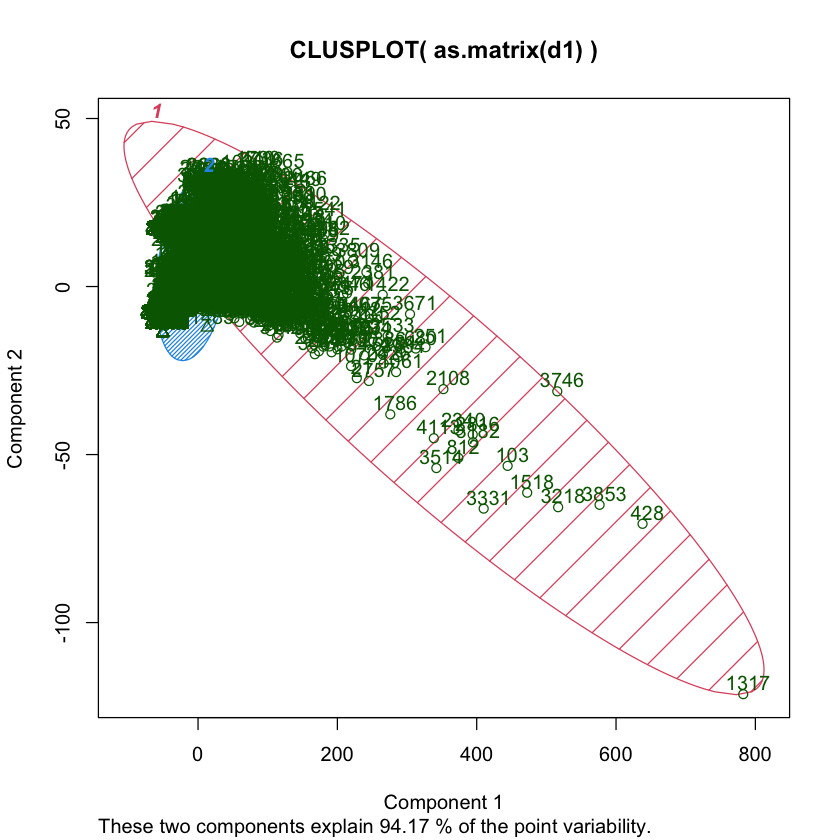

In [169]:
clusplot(as.matrix(d1), kfit1$cluster, color=T, shade=T, labels=2, lines=0)

使用最经常使用的词语构建集群

Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”
Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”


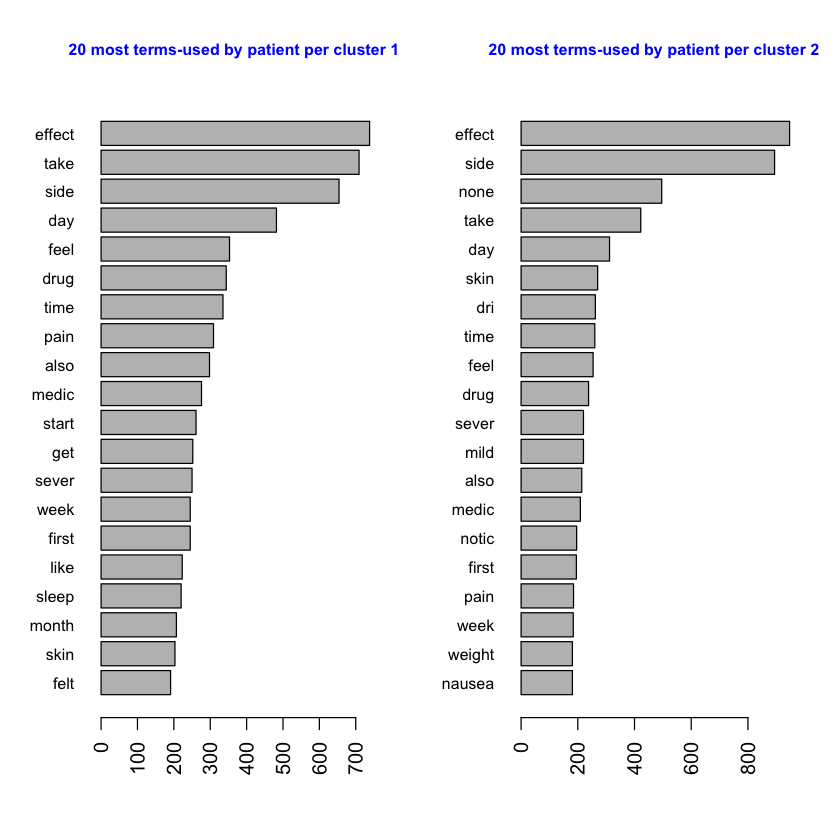

In [170]:
# 为两个集群建立语料库

ncl1=2
for (i in 1:ncl1) {
  name = paste("cl1_corp_", i, sep = "")
  assign(name, docs1[match(cl1[[i]], names(docs1))])
} 

Tdm1 = list()

# 为每个集群创建TDM的清单
for (i in 1:ncl1) {
  bigram_dtm1_i = TermDocumentMatrix(get(paste("cl1_corp_",i,sep="")))
  tdm1_i <- as.matrix(bigram_dtm1_i)
  Tdm1[paste("cluster_",i,sep="")] = list(tdm1_i)
}

# 画图显示每个集群的频率最高的20个关键词
par(mfrow = c(1,2))
for (i in 1:ncl1) {
  cl1_m = as.matrix(Tdm1[[i]])
  barplot(sort(sort(rowSums(cl1_m), decreasing = TRUE)[1:20], decreasing = FALSE),
          las = 2,
          horiz = TRUE,
          decreasing = FALSE, 
          main = paste("20 most terms-used by patient per cluster", i, sep = " "),
          cex.main = 0.8,
          cex.names = 0.8,
          col.main = "blue")
}

可以看到，药物的副作用情况主要分为两大类。

第一组包括以下关键词："无"、"dri"、"温和"、"notic"、"恶心"、"体重 "等。这可能表明医生开出的药物在大多数情况下没有任何副作用，然而，随着时间的推移，它们会引起轻微的恶心和体重下降。

第二组包括以下关键词："得到"、"喜欢"、"睡眠"、"皮肤"等。这组药物可引起皮肤过敏反应和嗜睡。


# 5.3 benefitsReview

先确定最佳的集群数。

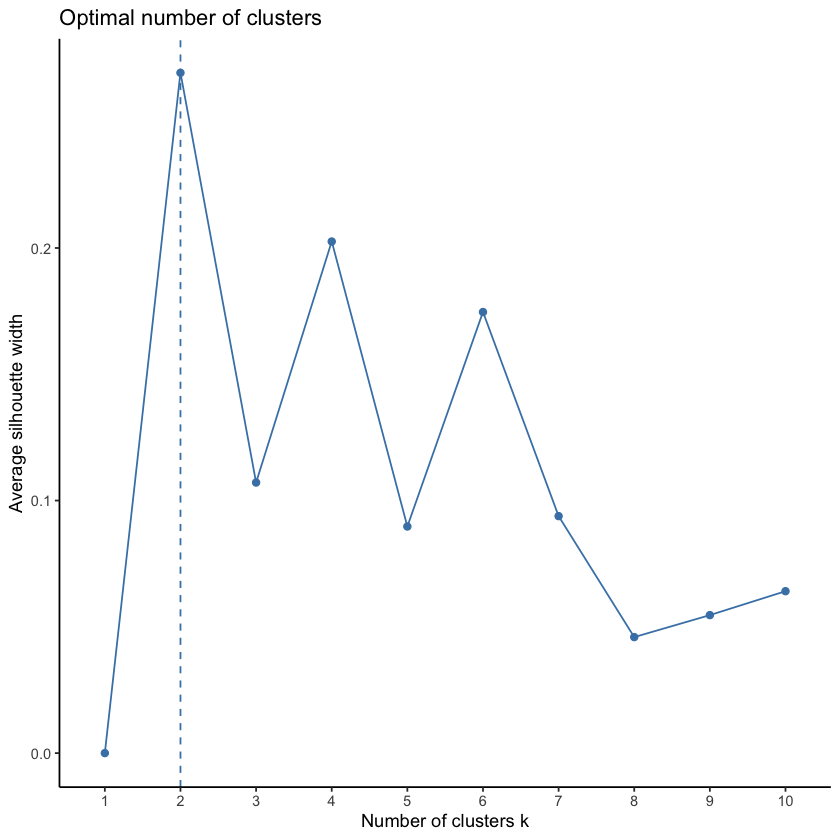

In [184]:
fviz_nbclust(m2, FUNcluster = kmeans, method = "silhouette") + theme_classic() 

根据Silhouette统计，kmeans的最佳集群数为2

# 5.3.1 K Means 聚类分析

In [175]:
# 计算文件向量之间的距离
d2 <- dist(m2, method="euclidian")
# k means - k=2
ncl2=2
kfit2 <- kmeans(d2, ncl2, nstart=100)

创建带有药物ID的集群列表

In [176]:
cl_k2 = as.data.frame(kfit2$cluster)

# 生成带有药物ID的集群列表
ncl2 = 2
cl2 = list()
for (i in 1:ncl2) {
cl2[paste("cl2_",i, sep = "")] = list(rownames(subset(cl_k2, cl_k2 == i)))
}
#cl2

画图显示两个集群

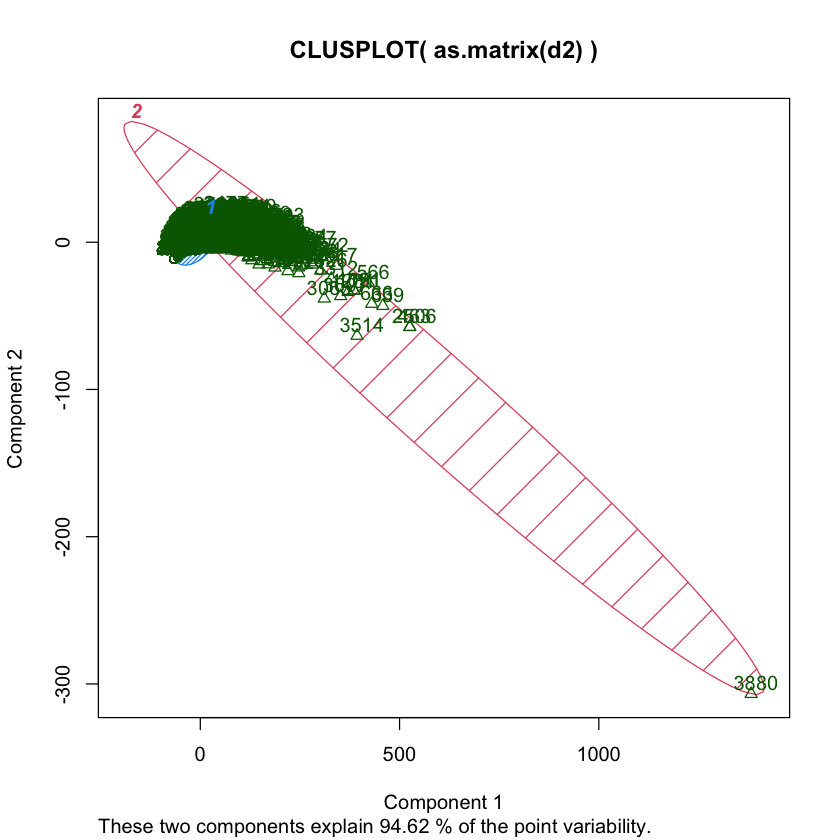

In [177]:
clusplot(as.matrix(d2), kfit2$cluster, color=T, shade=T, labels=2, lines=0)

让我们用最经常使用的词来分析所建群组的可能主题。

Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”
Warning message in plot.window(xlim, ylim, log = log, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty, :
“"decreasing" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"decreasing" is not a graphical parameter”
Warning message in axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...):
“"decreasing" is not a graphical parameter”


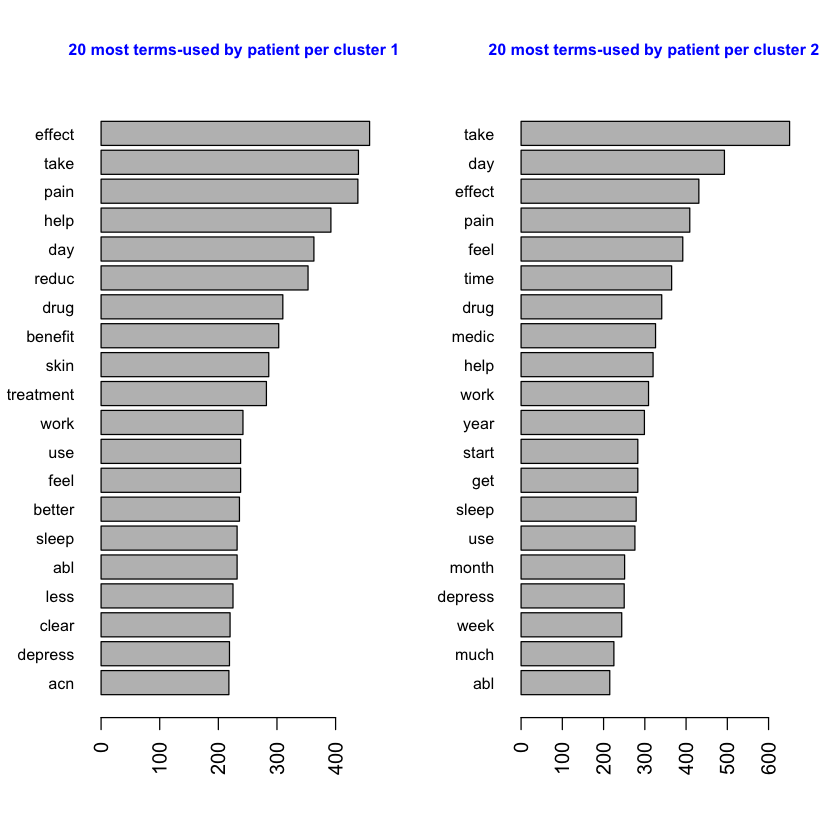

In [178]:
# 创建语料库

ncl2=2
for (i in 1:ncl2) {
  name = paste("cl2_corp_", i, sep = "")
  assign(name, docs2[match(cl2[[i]], names(docs2))])
} 

Tdm2 = list()

# 创建TDM
for (i in 1:ncl2) {
  bigram_dtm2_i = TermDocumentMatrix(get(paste("cl2_corp_",i,sep="")))
  tdm2_i <- as.matrix(bigram_dtm2_i)
  Tdm2[paste("cluster_",i,sep="")] = list(tdm2_i)
}

# 画图
par(mfrow = c(1,2))
for (i in 1:ncl2) {
  cl2_m = as.matrix(Tdm2[[i]])
  barplot(sort(sort(rowSums(cl2_m), decreasing = TRUE)[1:20], decreasing = FALSE),
          las = 2,
          horiz = TRUE,
          decreasing = FALSE, 
          main = paste("20 most terms-used by patient per cluster", i, sep = " "),
          cex.main = 0.8,
          cex.names = 0.8,
          col.main = "blue")
}

药物的有效性评论可以分为两大类。

第一组包括以下术语。"时间"、"年"、"月"、"周"、"医疗"、"起效"、"得到"、"开始"、"很多 "等等。这可能表明医生开出的这组药物有不同的治疗时间（一周、10天、一个月、一年）。观察表明，治疗的有效性来自：改善睡眠，减少焦虑和改善幸福感。

第二组包括以下术语。"减少"、"受益"、"皮肤"、"更好"、"清晰 "等。这组药物的特点是疗效更好。它是有利可图的，快速的。它能更好地清洁皮肤，改善病人的一般状况。

# 总结

我们项目的目标是根据处方药的总体评论，有效性评论，以及副作用评论，对这些评论的文本数据以及关键词进行分类。

首先，我们对文本的主体语料库进行识别，然后进行数据清理，并对语料库进行描述性统计，并准备文档-术语矩阵进行分析。接下来使用Kmeans聚类分析对于每个变量：处方药的有效性、药物的副作用和总体评论进行分析，并且都得到了2个类群。

希望上述意见对病人选择药物有帮助，使得患者不必浪费时间在网站上搜索关于所用药物的信息，使他们更加快速方便的找到他们需要的药品。
